# Imports

In [1]:
import pandas as pd
import plotly.express as px
from pathlib import Path

import yaml
import seaborn as sns
import optuna.visualization as vis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import xgboost as xgb
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import wandb
import os

# Constants

In [2]:
# Define directories
PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
DATA_DIR = ARTIFACTS_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
SPLIT_DATA_DIR = DATA_DIR / "split"
FEATURES_DIR = DATA_DIR / "features"
MODEL_DIR = ARTIFACTS_DIR / "models"
PARAMS_FILE = PROJECT_ROOT / "params.yaml"

# Constants
TARGET_COLUMN = "churn"
CUSTOMER_ID_COLUMN_RAW = "customerid"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
use_wandb = True
if use_wandb:
    wandb_project = os.getenv("WANDB_PROJECT")
    run = wandb.init(
        project=wandb_project,
        job_type="hyperparameter-tuning",
        config={
            "target_column": TARGET_COLUMN,
            "test_size": TEST_SIZE,
            "random_state": RANDOM_STATE,
        },
    )
    print(f"W&B initialized: {run.name}")

wandb: Currently logged in as: krabczewski (muflondev) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B initialized: glamorous-durian-9


# Data loading

In [4]:
csv_file = next(RAW_DATA_DIR.glob("*.csv"))
df = pd.read_csv(csv_file)
df.head()

if use_wandb:
    dataset_artifact = wandb.Artifact(
        name="churn-dataset-raw",
        type="dataset",
        description="Raw customer churn dataset",
    )
    dataset_artifact.add_file(str(csv_file))
    wandb.log_artifact(dataset_artifact)

In [5]:
df.columns = [col.replace(" ", "_").lower() for col in df.columns]
df = df.drop(columns=[CUSTOMER_ID_COLUMN_RAW])
df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,53,Female,58,24,9,2,Standard,Annual,533,18,0


## Exploratory Data Analysis

In [6]:
fig = px.pie(df, names="churn", title="Churn Distribution")
fig.show()

if use_wandb:
    churn_counts = df[TARGET_COLUMN].value_counts().to_dict()
    wandb.log(
        {"churn_distribution": churn_counts, "churn_rate": df[TARGET_COLUMN].mean()}
    )

    wandb.log({"churn_pie_chart": fig})

In [7]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numerical_cols].describe()

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


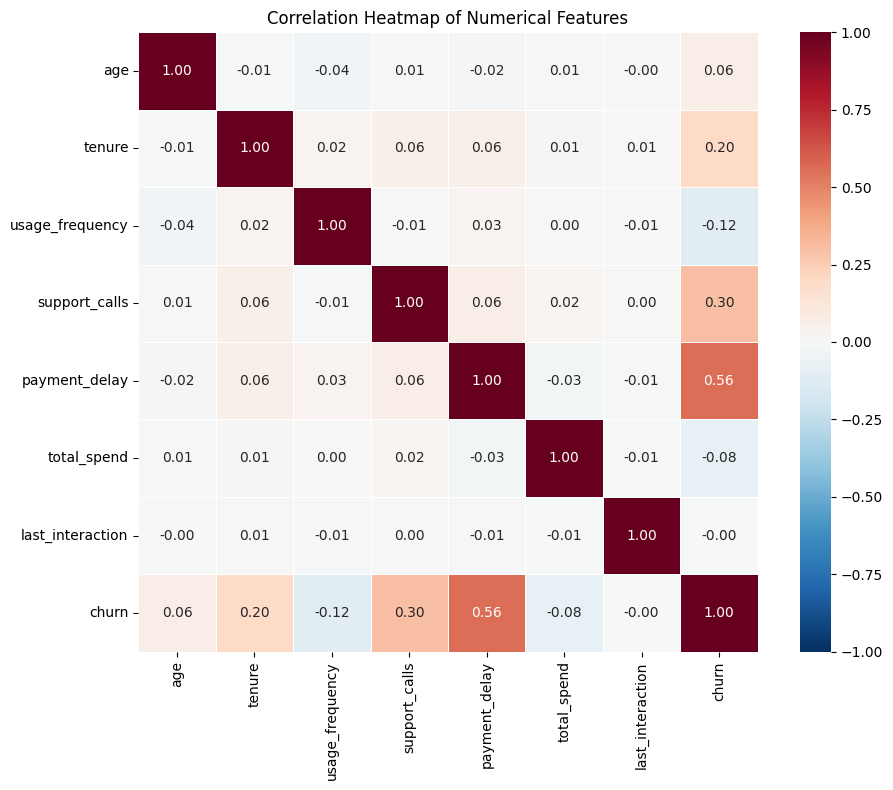

<Figure size 640x480 with 0 Axes>

In [8]:
correlation = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    annot=True,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    fmt=".2f",
    linewidths=0.5,
    square=True,
)

plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

if use_wandb:
    wandb.log({"correlation_heatmap": wandb.Image(plt)})

## Data Splitting

In [9]:
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_output_file = SPLIT_DATA_DIR / "train.csv"
test_output_file = SPLIT_DATA_DIR / "test.csv"

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (51499, 11), Test shape: (12875, 11)


## Feature Engineering

In [10]:
categorical_cols = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

print(f"Categorical columns: {categorical_cols}")

Categorical columns: ['gender', 'subscription_type', 'contract_length']


In [11]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
encoder.fit(X_train[categorical_cols])

X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index,
)
X_train_final = X_train.drop(columns=categorical_cols).join(X_train_encoded)

X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index,
)
X_test_final = X_test.drop(columns=categorical_cols).join(X_test_encoded)

train_featured = pd.concat([X_train_final, y_train], axis=1)
test_featured = pd.concat([X_test_final, y_test], axis=1)

train_featured.head()

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend,last_interaction,gender_Male,subscription_type_Premium,subscription_type_Standard,contract_length_Monthly,contract_length_Quarterly,churn
17402,56,40,12,1,0,731,24,0.0,0.0,1.0,1.0,0.0,0
20461,38,30,4,4,9,179,6,0.0,0.0,1.0,0.0,0.0,0
63787,22,30,21,8,19,716,2,1.0,1.0,0.0,0.0,1.0,1
12218,45,12,26,10,10,1000,29,1.0,1.0,0.0,1.0,0.0,0
6831,59,37,13,6,22,727,6,0.0,0.0,1.0,0.0,1.0,1


## Hyperparameter Tuning with Optuna

In [ ]:
def objective(trial):
    param_space = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
    }

    model = xgb.XGBClassifier(**param_space)
    model.fit(
        X_train_final,
        y_train,
        eval_set=[(X_test_final, y_test)],
        verbose=False,
    )

    y_pred_proba = model.predict_proba(X_test_final)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    return auc


callbacks = (
    [
        WeightsAndBiasesCallback(
            metric_name="accuracy", wandb_kwargs={"project": wandb_project}
        )
    ]
    if use_wandb
    else None
)

study = optuna.create_study(direction="auc", study_name="hyperparameter tuning")
study.optimize(objective, n_trials=20, show_progress_bar=True, callbacks=callbacks)

print("Best trial:")
trial = study.best_trial
print(f"  Value (AUC): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

/tmp/ipykernel_35830/778684681.py:30: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



churn_rate,▁
churn_rate,0.47369


[I 2025-07-03 14:57:05,460] A new study created in memory with name: xgboost-tuning


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-07-03 14:57:06,179] Trial 0 finished with value: 0.9998693100636042 and parameters: {'learning_rate': 0.08024987540638896, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.7870690737517129, 'colsample_bytree': 0.6200794729328267, 'subsample': 0.5841235822109097, 'n_estimators': 149}. Best is trial 0 with value: 0.9998693100636042.
[I 2025-07-03 14:57:06,953] Trial 1 finished with value: 0.9999998306184865 and parameters: {'learning_rate': 0.1884227367207187, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.09510752188784766, 'colsample_bytree': 0.5987443549645253, 'subsample': 0.5137355840832836, 'n_estimators': 279}. Best is trial 1 with value: 0.9999998306184865.
[I 2025-07-03 14:57:07,664] Trial 2 finished with value: 0.9997826835180947 and parameters: {'learning_rate': 0.012286715709948302, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 0.15438405124444343, 'colsample_bytree': 0.821942262418137, 'subsample': 0.5841157336715499, 'n_estimators': 191}. Best is trial 1 with

In [13]:
best_params = study.best_params
best_params.update(
    {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": RANDOM_STATE,
    }
)

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_final, y_train)

y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

tuned_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_pred_proba),
}

print("\nMetrics with tuned parameters:")
print(tuned_metrics)


Metrics with tuned parameters:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'roc_auc': 1.0}


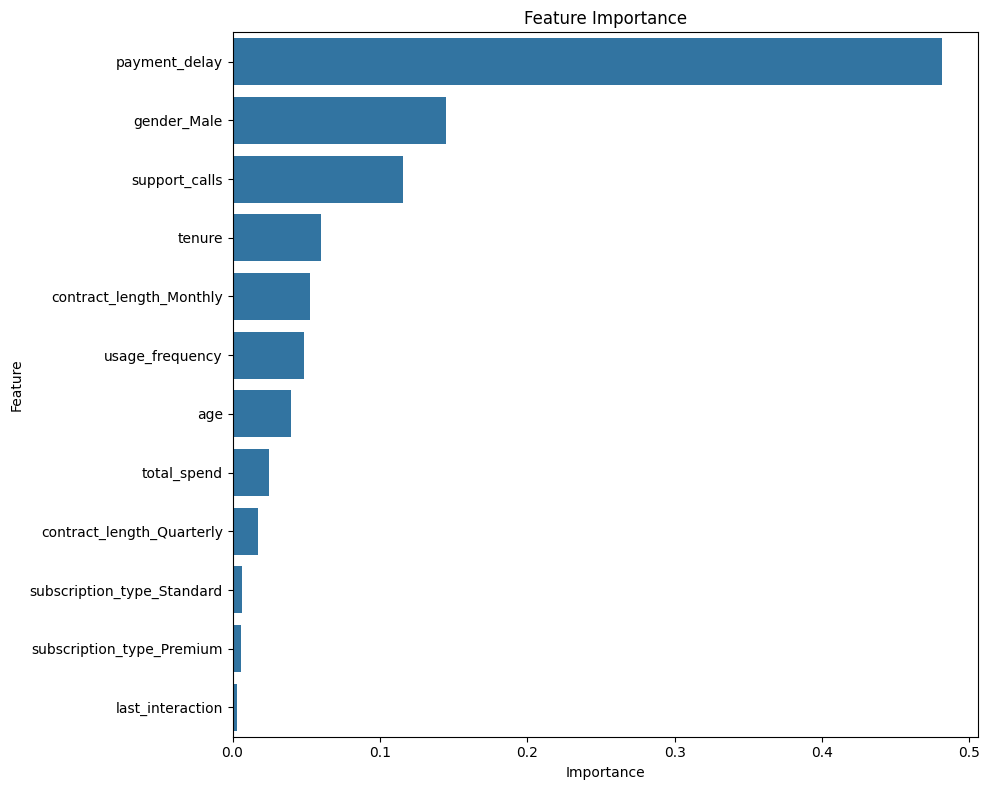

In [14]:
if use_wandb:
    wandb.log(tuned_metrics)

    feature_importance = pd.DataFrame(
        {
            "Feature": X_train_final.columns,
            "Importance": best_model.feature_importances_,
        }
    ).sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(20))
    plt.title("Feature Importance")
    plt.tight_layout()

    wandb.log(
        {
            "feature_importance": wandb.Image(plt),
            "feature_importance_data": wandb.Table(dataframe=feature_importance),
        }
    )

In [15]:
tuned_params_file = PROJECT_ROOT / "params_tuned.yaml"
with open(tuned_params_file, "w") as f:
    yaml.dump({"xgboost": best_params}, f)

print(f"Saved tuned parameters to {tuned_params_file}")

if use_wandb:
    params_artifact = wandb.Artifact(
        name="tuned-parameters",
        type="parameters",
        description="Tuned XGBoost parameters",
    )
    params_artifact.add_file(str(tuned_params_file))
    wandb.log_artifact(params_artifact)

Saved tuned parameters to /home/rabadaba/mlops/params_tuned.yaml


In [ ]:
model_path = MODEL_DIR / "xgboost_tuned.json"
best_model.save_model(str(model_path))
print(f"Saved tuned model to {model_path}")

if use_wandb:
    model_artifact = wandb.Artifact(
        name="notebook-churn-model",
        type="model",
        description="Tuned XGBoost model for customer churn prediction",
        metadata=best_params,
    )
    model_artifact.add_file(str(model_path))
    wandb.log_artifact(model_artifact)

Saved tuned model to /home/rabadaba/mlops/artifacts/models/xgboost_tuned.json


In [17]:
cm = confusion_matrix(y_test, y_pred)
cm_display = px.imshow(
    cm,
    text_auto=True,
    labels=dict(x="Predicted", y="Actual"),
    x=["Not Churn", "Churn"],
    y=["Not Churn", "Churn"],
    title="Confusion Matrix",
)

wandb.log({"confusion_matrix": cm_display})

In [18]:
if use_wandb:
    run.finish()